# ***Section 1. Market Impact of Speech-Feature Shifts*** 

We frame this as an **empirical research question**:  
do **shifts in CEO speech features** (e.g., uncertainty, hedging, optimism) have measurable effects on subsequent market behavior?

Let $X_t$ denote the extracted speech features at day $t$. We define the **speech-feature shift** as
$$
\Delta X_t = X_t - X_{t-1},
$$
(or more generally, the change over a short window). The objective is to test whether $\Delta X_t$ is associated with market outcomes such as **future returns** (e.g., $r_{t+1:t+k}$) or **volatility**.

In this study, we **do not** incorporate $\Delta X_t$ into the MSAR model. Instead, we perform a **feature-shift screening analysis** by computing simple association metrics between $\Delta X_t$ and market targets, including the **Pearson correlation** and its corresponding **p-value**:
$$
\rho\!\left(\Delta X_t,\; Y_{t+k}\right), \qquad p\text{-value}(\rho),
$$
where $Y_{t+k}$ denotes the chosen market response (e.g., cumulative return over the next $k$ trading days).

This analysis provides an interpretable first-step assessment of whether changes in CEO language are statistically linked to subsequent market movements and motivates which speech features (and horizons) are most promising for downstream modeling.



We use CEO **speech and interview transcripts** from  
`ada-2025-project-alwaysdominatingacademics\data\2016_2020_speech.zip`  
to extract linguistic indicators that may influence market behavior.

The analysis is implemented in  
`ada-2025-project-alwaysdominatingacademics\src\models\NLP.py`,  
which performs **semantic analysis** using OpenAI’s embedding model.  
Because it relies on the **OpenAI API**, a valid API key (`OPENAI_API_KEY`) is required to run this script.

---



In [6]:
from pathlib import Path
from src.models.NLP_model import SpeechEmbeddingAnalyzer 

analyzer = SpeechEmbeddingAnalyzer(topic_topk=5)
in_dir = r".\data\2016_2020_speech.zip"
#Unzip the dir
df = analyzer.transform_folder(in_dir)
out = Path(in_dir).with_name("transcripts_2016_2020_analysis.xlsx")
df.to_excel(out, index=False)

Analyzing (embeddings): 0it [00:00, ?it/s]


## Text → Features → Market

1. **Transcript Preprocessing & Chunking**  
   Each CEO transcript is cleaned/normalized and split into chunks (≤ 4000 characters) to respect model limits while keeping sentence boundaries.

2. **Embedding-Based Feature Extraction (Semantic Signals)**  
   Each chunk is embedded using OpenAI `text-embedding-3-small` (1536-d). Chunk embeddings are mean-pooled to a document embedding:
   $$
   \mathbf{v}_{\text{doc}}=\frac{1}{N}\sum_{i=1}^{N}\mathbf{v}_i
   $$
   The document embedding is compared to predefined **anchor embeddings** (cosine similarity) to produce semantic feature intensities such as:
   sentiment (pos/neg), uncertainty (high/low), emotions, linguistic fingerprints (optimism, hedging, self-reference, complexity), and business topics.
   Similarities are scaled to \([0,1]\) and interpreted as feature strengths.

3. **Lexical Metrics (Explainable Signals)**  
   Add transparent count-based features (e.g., hedging words, self-references, jargon) and readability metrics (e.g., Flesch–Kincaid grade).

4. **Transcript-Level Feature Output**  
   Each transcript yields one feature row (e.g., `sentiment`, `uncertainty`, `emo_*`, `fp_*`, topic weights), exported to Excel for downstream analysis.

5. **CEO-Relative Feature Shifts (Within-CEO Normalization)**  
   Convert transcript features into CEO-relative signals (rolling z-scores or deltas vs a CEO-specific rolling baseline), then compute feature shifts:
   $$
   \Delta X_t = X_t - X_{t-1}.
   $$

6. **Daily Aggregation & Trading-Day Alignment**  
   Aggregate multiple speeches on the same day into a daily signal (mean/median), record `speech_present`, `n_speeches`, `n_tickers`, then map each speech-day to the **next trading day** and merge with market data.

7. **Forward Return Labels (Multi-Horizon)**  
   Compute forward cumulative returns over windows $W\in\{3,5,10,20\}$ (e.g., `cum_ret_3`, `cum_ret_5`, …).

8. **Correlation Screening & Visualization**  
   Rank speech-feature shifts by Pearson/Spearman correlation (with p-values) against forward returns.


In [8]:
import pandas as pd
path = r".\src\data_cleaned\processed_NLP\transcripts_2016_2020_analysis.xlsx"
df = pd.read_excel(path)

# show the processed dataset
print("Number of rows:", len(df))
df.head()


Number of rows: 188


,file,sentiment,sent_conf,uncertainty,emo_joy,emo_anger,emo_fear,emo_sadness,emo_trust,emo_surprise,fp_optimism,fp_hedging_rate,fp_self_reference_rate,fp_jargon_density,fp_complexity_fk_grade,topics
0,2016-Apr-19-INTC.txt,Neutral,0.0945,0.5006,0.5803,0.6015,0.5889,0.5818,0.6186,0.5808,0.599881,0.008272,0.039765,0.006877,10.411909,revenue growth(0.09); ai strategy and product ...
1,2016-Apr-20-ASML.txt,Neutral,0.0729,0.4978,0.5825,0.5859,0.5888,0.5878,0.6027,0.5962,0.582331,0.009172,0.042839,0.003544,11.403505,customer demand and pipeline(0.09); revenue gr...
2,2016-Apr-21-AMD.txt,Neutral,0.0825,0.5139,0.5837,0.6048,0.5773,0.5844,0.6001,0.5814,0.594846,0.009263,0.049520,0.004346,10.654924,ai strategy and product roadmap(0.09); revenue...
3,2016-Apr-21-GOOGL.txt,Neutral,0.1187,0.5003,0.5861,0.5902,0.5728,0.5740,0.6152,0.5982,0.597291,0.008664,0.047495,0.003445,10.347967,revenue growth(0.09); ai strategy and product ...
4,2016-Apr-21-MSFT.txt,Neutral,0.1298,0.5064,0.6018,0.5934,0.5880,0.5911,0.6211,0.5898,0.596305,0.008474,0.047742,0.009507,11.526360,revenue growth(0.09); ai strategy and product ...


In [9]:
# Load the normalized speech dataset
path = r".\src\data_cleaned\processed_NLP\transcripts_2016_2020_analysis_real.xlsx"
df = pd.read_excel(path)
df.head()

,file,sentiment,sent_conf,uncertainty,emo_joy,emo_anger,emo_fear,emo_sadness,emo_trust,emo_surprise,fp_optimism,fp_hedging_rate,fp_self_reference_rate,fp_jargon_density,fp_complexity_fk_grade,topics,accompany
0,2016-01-14 00:00:00,Neutral,0.486364,0.515306,0.278970,0.669584,0.409253,0.727099,0.674888,0.444444,0.580135,0.369960,0.483812,0.216670,0.416310,revenue growth(0.09); ai strategy and product ...,INTC
1,2016-01-19,Neutral,0.334848,0.908163,0.068670,0.835886,0.279359,0.765267,0.000000,0.000000,0.444402,0.636315,0.689980,0.461872,0.674308,ai strategy and product roadmap(0.09); revenue...,AMD
2,2016-01-20,Neutral,0.344697,0.117347,0.214592,0.470460,0.341637,0.729008,0.192825,0.441734,0.339922,0.646061,0.428794,0.147203,0.399194,customer demand and pipeline(0.09); ai strateg...,ASML
3,2016-01-26,Neutral,0.415909,0.658163,0.706009,0.606127,0.693950,0.780534,0.513453,0.696477,0.525272,0.610681,0.150963,0.219528,0.000000,revenue growth(0.09); ai strategy and product ...,AAPL
4,2016-01-28,Neutral,0.800000,0.397959,0.686695,0.575492,0.241993,0.801527,0.522422,0.558266,0.534974,0.275968,0.641977,0.235198,0.737211,revenue growth(0.09); ai strategy and product ...,MSFT


In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Make plots look a bit larger by default
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

### Paths & configuration

This block specifies where the input data lives and defines the key hyperparameters that control the entire pipeline:

- **Input paths**
  - `speech_path`: transcript-level feature table exported from the NLP/embedding pipeline (Excel).
  - `market_path`: daily market data (CSV), including prices/returns and any precomputed labels.

- **Core parameters**
  - `W_LIST`: forward-return horizons (in **trading days**) used to build targets such as `cum_ret_3`, `cum_ret_5`, etc.
  - `ROLL_N`: rolling baseline length per CEO, computed from the **past N speeches** (excluding the current day) to avoid look-ahead.
  - `MODE`: CEO-relative normalization method:
    - `"zscore"` → rolling z-score vs CEO baseline
    - `"delta"` → deviation from CEO rolling mean
  - `DAILY_AGG`: how to aggregate multiple speeches on the same calendar day into one daily signal (`mean` or `median`).
  - `EPS`: small constant for numerical stability (e.g., when dividing by rolling std).
  - `TOPK`: number of top-ranked features to show in tables/plots.

In [11]:
# ===== Paths =====
speech_path = r".\src\data_cleaned\processed_NLP\transcripts_2016_2020_analysis_real.xlsx"
market_path = r".\src\data_cleaned\processed_NLP\NASDAQ-Index_labeled.csv"

# ===== Parameters =====
W_LIST = [3, 5, 10, 20]      # forward windows in trading days
ROLL_N = 10                  # baseline built from past N speeches per CEO (excluding today)
MODE = "zscore"              # "zscore" or "delta"
DAILY_AGG = "mean"           # "mean" or "median"
EPS = 1e-9                   # numerical stability for division
TOPK = 15                    # top features to display/plot

### Load data and standardize date fields

This block loads the **speech feature table** and the **market time series**, then ensures both datasets share a clean `date` column for merging later.

Key steps:
- Read the speech features from Excel and the market data from CSV.
- Parse dates:
  - Speech dates are extracted from the `file` field (as in the original script).  
    If your dataset already contains a dedicated date column, you can replace this parsing step.
  - Market dates are parsed from the `date` column and the table is sorted chronologically.
- Ensure a `logret` column exists in the market table:
  - If `logret` is already provided, nothing changes.
  - Otherwise, compute log returns from an available close-price column (`close`, `Close`, `adj_close`, `Adj Close`).
- Print basic dataset diagnostics (row counts and market date range).

In [12]:
speech = pd.read_excel(speech_path)
mkt = pd.read_csv(market_path)

# --- Parse dates ---
# Speech date is parsed from "file" (as in your original script).
# If you already have a dedicated date column, replace this line accordingly.
speech["date"] = pd.to_datetime(speech["file"], errors="coerce")

mkt["date"] = pd.to_datetime(mkt["date"], errors="coerce")
mkt = mkt.sort_values("date").reset_index(drop=True)

# --- Ensure logret exists ---
# If your CSV already has "logret", this does nothing.
# Otherwise, compute from "close" (or "Close") if available.
if "logret" not in mkt.columns:
    close_col = None
    for cand in ["close", "Close", "adj_close", "Adj Close"]:
        if cand in mkt.columns:
            close_col = cand
            break
    if close_col is None:
        raise ValueError("Market file must contain 'logret' OR a close price column (e.g., 'close').")
    mkt["logret"] = np.log(mkt[close_col]).diff()

print("Speech rows:", len(speech))
print("Market rows:", len(mkt))
print("Market date range:", mkt["date"].min(), "→", mkt["date"].max())

Speech rows: 188
Market rows: 1259
Market date range: 2016-01-04 00:00:00 → 2020-12-31 00:00:00


### Select numeric speech features for analysis

Here we define the set of speech features that will be tested against future market returns.  
We exclude non-feature or non-numeric columns (e.g., identifiers and text fields such as `file`, `date`, `sentiment`, `topics`, `accompany`) and then automatically collect all remaining **numeric** columns from the speech table.

The resulting list `feature_cols` is the final feature set used in later steps (CEO-relative normalization, daily aggregation, and correlation screening). We also print the selected feature names and the total count as a quick sanity check.


In [13]:
exclude = {"file", "date", "sentiment", "topics", "accompany"}
feature_cols = [
    c for c in speech.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(speech[c])
]

print("Numeric features:", feature_cols)
print("Num numeric features:", len(feature_cols))

Numeric features: ['sent_conf', 'uncertainty', 'emo_joy', 'emo_anger', 'emo_fear', 'emo_sadness', 'emo_trust', 'emo_surprise', 'fp_optimism', 'fp_hedging_rate', 'fp_self_reference_rate', 'fp_jargon_density', 'fp_complexity_fk_grade']
Num numeric features: 13


### Build CEO-relative feature shifts (rolling baseline)

This step converts raw speech features into **within-CEO changes** by normalizing each feature against a CEO-specific rolling baseline.

- Drop rows missing `date` or `accompany` (CEO/ticker identifier), then sort by CEO and time.
- For each CEO, compute a rolling mean and standard deviation over the past `ROLL_N` speeches, using `shift(1)` to ensure the current speech is not included (no look-ahead).
- Transform features using the chosen `MODE`:
  - `delta`: deviation from the rolling mean
  - `zscore`: z-score relative to the rolling mean and std (with `EPS` for stability)
- Concatenate all CEOs back into one table `speech_chg` and collect the shifted-feature columns (`*_d` or `*_z`) for later analysis.


In [14]:
speech = speech.dropna(subset=["date", "accompany"]).copy()
speech = speech.sort_values(["accompany", "date"]).reset_index(drop=True)

out = []
for ticker, g in speech.groupby("accompany", sort=False):
    g = g.sort_values("date").copy()

    # Rolling baseline: only past speeches. shift(1) excludes the current speech from its own baseline.
    mu = g[feature_cols].rolling(ROLL_N, min_periods=3).mean().shift(1)
    sd = g[feature_cols].rolling(ROLL_N, min_periods=3).std(ddof=0).shift(1)

    if MODE == "delta":
        changed = g[feature_cols] - mu
        changed_cols = [f"{c}_d" for c in feature_cols]
    else:
        changed = (g[feature_cols] - mu) / (sd + EPS)
        changed_cols = [f"{c}_z" for c in feature_cols]

    changed.columns = changed_cols
    g2 = pd.concat([g[["date", "accompany"]], changed], axis=1)
    out.append(g2)

speech_chg = pd.concat(out, ignore_index=True)
chg_cols = [c for c in speech_chg.columns if c.endswith("_z") or c.endswith("_d")]

print("Speech change rows:", len(speech_chg))
print("Change feature columns:", len(chg_cols))

Speech change rows: 188
Change feature columns: 13


### Aggregate speech shifts to a daily signal (and remove empty days)

This step collapses the CEO-level speech-shift table into a **single daily time series** that can be merged with market data.

- **Daily aggregation:** for each calendar date, aggregate all speech-shift features (`chg_cols`) across speeches using either:
  - **mean** (default), or
  - **median** (more robust to outliers), controlled by `DAILY_AGG`.
- **Coverage diagnostics:** add two daily volume controls:
  - `n_speeches`: number of speech records on that date
  - `n_tickers`: number of distinct CEOs/tickers speaking on that date
- **Sorting:** reset index and sort by `date` to ensure a clean chronological series.
- **Drop empty feature-days:** remove dates where **all** shift features are NaN (e.g., early days before a CEO has enough history to form a rolling baseline).  
  This keeps only days with at least one valid speech signal, so downstream correlations aren’t diluted by “no-information” rows.

Finally, we print the number of remaining daily rows and preview the first few entries.


In [15]:
if DAILY_AGG == "median":
    daily = speech_chg.groupby("date")[chg_cols].median()
else:
    daily = speech_chg.groupby("date")[chg_cols].mean()

daily["n_speeches"] = speech_chg.groupby("date").size()
daily["n_tickers"] = speech_chg.groupby("date")["accompany"].nunique()

daily = daily.reset_index().sort_values("date").reset_index(drop=True)

print("Daily rows:", len(daily))
daily.head(20)

if DAILY_AGG == "median":
    daily = speech_chg.groupby("date")[chg_cols].median()
else:
    daily = speech_chg.groupby("date")[chg_cols].mean()

daily["n_speeches"] = speech_chg.groupby("date").size()
daily["n_tickers"]  = speech_chg.groupby("date")["accompany"].nunique()

daily = daily.reset_index().sort_values("date").reset_index(drop=True)


daily = daily.loc[daily[chg_cols].notna().any(axis=1)].reset_index(drop=True)

print("Daily rows (non-all-NaN):", len(daily))
daily.head(20)



Daily rows: 151
Daily rows (non-all-NaN): 126


,date,sent_conf_z,uncertainty_z,emo_joy_z,emo_anger_z,emo_fear_z,emo_sadness_z,emo_trust_z,emo_surprise_z,fp_optimism_z,fp_hedging_rate_z,fp_self_reference_rate_z,fp_jargon_density_z,fp_complexity_fk_grade_z,n_speeches,n_tickers
0,2016-10-18,-2.815678,0.297396,-1.320040,-0.693539,-5.394301,-1.682231,-1.441674,-0.461658,4.635426,-0.217841,-0.190340,0.025917,0.392752,1,1
1,2016-10-19,1.109059,-1.084567,0.610679,-1.961147,-0.088406,-2.070815,4.621967,-0.009723,0.767444,2.023887,1.851273,1.218995,-0.300651,1,1
2,2016-10-20,3.127992,-1.972270,1.606078,6.963393,0.946314,-0.543116,2.793426,1.735002,2.874050,0.158984,-0.985631,-0.783888,5.318095,2,2
3,2016-10-25,2.994131,-1.789116,0.413043,-1.662803,-3.035525,-3.787472,1.805203,0.538933,1.043686,2.579689,-0.331833,-1.005486,-0.694504,1,1
4,2016-10-27,-0.857640,-1.530683,0.081779,-0.178003,1.449958,-0.641941,0.303457,-0.106117,-3.637159,-1.191114,3.331041,-16.460975,1.764699,2,2
5,2016-11-10,1.738621,-0.056444,-0.492768,-2.104449,-1.933634,-4.395189,-0.311283,-2.993087,2.286135,3.472256,-0.939245,-3.399956,-0.159724,1,1
6,2016-11-16,-1.102065,2.757717,0.934537,1.329745,3.119253,0.113244,-0.139231,-0.016999,-1.257781,-0.300099,-0.692173,-1.264469,3.828090,1,1
7,2016-12-21,1.259567,-3.687720,2.236337,-1.028507,-1.478529,-0.925313,1.900724,3.372660,1.072990,9.254359,-5.327267,-2.700640,-1.395800,1,1
8,2017-01-18,1.411401,2.653947,-0.133114,-1.536063,0.118199,-0.678652,-0.382685,-1.186803,0.910688,2.380993,-1.644010,0.116291,0.626663,1,1
9,2017-01-26,3.270498,-3.722057,0.602654,0.423026,0.135790,-1.143364,0.250364,-0.327115,2.482952,4.072791,0.756449,0.343381,-0.049721,3,3


### Align speech signals to the next trading day (speech → market timing)

This step links each **daily speech signal** to the **market day it can realistically affect**.

- **Lag assumption:** we assume speech information starts impacting prices from the **next calendar day**, so we create:
  - `date_effect = date + 1 day`.
- **Next-trading-day mapping:** because `date_effect` may fall on weekends or holidays, we use an as-of merge with `direction="forward"` to map it to the **next available trading date** in the market table.
  - The resulting aligned trading day is stored as `mkt_date`.
- **Index mapping for fast horizons:** we convert `mkt_date` into a trading-day integer index `idx0` (based on the market dataframe row index).  
  This makes it easy to compute forward return windows (3/5/10/20 days) by simple index offsets.

Finally, we print the number of aligned rows and preview key columns (`date`, `date_effect`, `mkt_date`, `idx0`, plus coverage controls).


In [16]:
# Assume the speech affects the market starting from the next calendar day.
# merge_asof with direction='forward' maps it to the next available trading day.
daily["date_effect"] = daily["date"] + pd.Timedelta(days=1)

merged = pd.merge_asof(
    daily.sort_values("date_effect"),
    mkt[["date", "logret"]].rename(columns={"date": "mkt_date"}).sort_values("mkt_date"),
    left_on="date_effect",
    right_on="mkt_date",
    direction="forward",
)

# Map the aligned trading date to an integer index for fast forward-window calculations.
mkt_index = pd.Series(mkt.index.values, index=mkt["date"])
merged["idx0"] = merged["mkt_date"].map(mkt_index)

print("Merged rows:", len(merged))
merged[["date", "date_effect", "mkt_date", "idx0", "n_speeches", "n_tickers"]].head(10)

Merged rows: 126


,date,date_effect,mkt_date,idx0,n_speeches,n_tickers
0,2016-10-18,2016-10-19,2016-10-19,201,1,1
1,2016-10-19,2016-10-20,2016-10-20,202,1,1
2,2016-10-20,2016-10-21,2016-10-21,203,2,2
3,2016-10-25,2016-10-26,2016-10-26,206,1,1
4,2016-10-27,2016-10-28,2016-10-28,208,2,2
5,2016-11-10,2016-11-11,2016-11-11,218,1,1
6,2016-11-16,2016-11-17,2016-11-17,222,1,1
7,2016-12-21,2016-12-22,2016-12-22,246,1,1
8,2017-01-18,2017-01-19,2017-01-19,263,1,1
9,2017-01-26,2017-01-27,2017-01-27,269,3,3


### Compute forward return labels (multi-horizon)

This block creates the **future-return targets** used for correlation screening.

- Convert the market log-return series into a NumPy array (`logret_arr`) for efficient slicing.
- Define a helper `forward_sum(arr, idx0, W)` that:
  - starts at the aligned trading-day index `idx0`,
  - sums the next `W` daily log-returns,
  - returns `NaN` if `idx0` is missing or if the forward window runs past the end of the sample.
- For each horizon \(W \in W_{\text{LIST}}\), compute:
  - the forward cumulative **log return**:
    $$\text{cum\_logret}_W(t)=\sum_{j=0}^{W-1}\ell_{t+j}$$
  - and convert it into a forward cumulative **simple return**:
    $$\text{cum\_ret}_W(t)=\exp(\text{cum\_logret}_W(t)) - 1$$

Finally, we define the target columns (`cum_ret_3`, `cum_ret_5`, …) and summarize their distributions with `.describe()` as a sanity check.


In [17]:
logret_arr = mkt["logret"].to_numpy()

def forward_sum(arr, idx0, W):
    if pd.isna(idx0):
        return np.nan
    i = int(idx0)
    j = i + W
    if j > len(arr):
        return np.nan
    return np.nansum(arr[i:j])

for W in W_LIST:
    merged[f"cum_logret_{W}"] = merged["idx0"].apply(lambda i: forward_sum(logret_arr, i, W))
    merged[f"cum_ret_{W}"] = np.exp(merged[f"cum_logret_{W}"]) - 1

target_cols = [f"cum_ret_{W}" for W in W_LIST]
merged[target_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
cum_ret_3,126.0,0.002509,0.019832,-0.068545,-0.007781,0.003545,0.013826,0.056146
cum_ret_5,126.0,0.005582,0.025333,-0.086272,-0.006424,0.006324,0.019235,0.077516
cum_ret_10,126.0,0.012106,0.036773,-0.122387,-0.004819,0.016329,0.031555,0.101736
cum_ret_20,126.0,0.015285,0.051955,-0.244409,-0.011142,0.025357,0.045231,0.156887


### Correlation screening (feature shifts → forward returns)

This step ranks speech-feature shifts by how strongly they are associated with future market returns.

- Define `corr_report(df, ycol, features)` to compute, for each feature:
  - **Pearson correlation** (linear association) with the target `ycol`
  - **Spearman correlation** (rank-based, monotonic association) with the same target
  - corresponding **p-values**
  - the number of valid paired observations `n`
- Use a finite-value mask to drop any rows with NaNs/inf in either the feature or the target.
- Skip weakly supported estimates by requiring at least `n ≥ 30` valid samples.
- Store results in a tidy table with columns:
  - `feature`, `pearson_r`, `pearson_p`, `spearman_r`, `spearman_p`, `n`
- Add `abs_r = |pearson_r|` and sort descending to get a clear “top signals” ranking.

We run this report for each forward horizon \(W\in\{3,5,10,20\}\) and store them in `results[W]`.  
Finally, we display the top `TOPK` features for the 3-day horizon (`W=3`) as the default summary.


In [18]:
def corr_report(df, ycol, features):
    rows = []
    for feat in features:
        x = df[feat].to_numpy()
        y = df[ycol].to_numpy()
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() < 30:
            continue
        rp, pp = stats.pearsonr(x[mask], y[mask])
        rs, ps = stats.spearmanr(x[mask], y[mask])
        rows.append((feat, rp, pp, rs, ps, mask.sum()))
    res = pd.DataFrame(rows, columns=["feature", "pearson_r", "pearson_p", "spearman_r", "spearman_p", "n"])
    res["abs_r"] = res["pearson_r"].abs()
    return res.sort_values("abs_r", ascending=False)

results = {}
for W in W_LIST:
    ycol = f"cum_ret_{W}"
    sub = merged.dropna(subset=[ycol]).copy()
    results[W] = corr_report(sub, ycol, chg_cols)

# Show top features for W=3 by default
results[3].head(TOPK)

,feature,pearson_r,pearson_p,spearman_r,spearman_p,n,abs_r
1,uncertainty_z,0.205916,0.020711,0.182326,0.041016,126,0.205916
6,emo_trust_z,0.165582,0.063891,0.151418,0.090551,126,0.165582
3,emo_anger_z,0.150127,0.093366,0.106118,0.236952,126,0.150127
7,emo_surprise_z,0.135512,0.130292,0.104288,0.245181,126,0.135512
10,fp_self_reference_rate_z,-0.123422,0.168551,-0.147849,0.098504,126,0.123422
4,emo_fear_z,0.081271,0.365638,0.056744,0.527969,126,0.081271
2,emo_joy_z,0.064787,0.471065,0.042604,0.635732,126,0.064787
5,emo_sadness_z,0.042226,0.638734,0.020340,0.821148,126,0.042226
12,fp_complexity_fk_grade_z,0.031147,0.729175,0.011312,0.899961,126,0.031147
0,sent_conf_z,0.026899,0.764950,0.027696,0.758202,126,0.026899


### Feature Selection for MSAR Input

Based on the correlation screening results, **changes in CEO speech uncertainty** emerge as the most informative linguistic signal for market returns.  

Among all extracted speech features, the **within-CEO standardized uncertainty shift** (`uncertainty_z`) shows the **strongest and statistically significant correlation** with forward 3-day cumulative returns:
$$
\text{Pearson } r \approx 0.21,\quad p \approx 0.02,
$$
$$
\text{Spearman } r \approx 0.18,\quad p \approx 0.04.
$$

The uncertainty signal is constructed in two steps. First, transcript-level uncertainty is standardized **within each CEO** using a rolling baseline:
$$
\text{uncertainty\_z}_t
=
\frac{\text{uncertainty}_t - \mu^{(\text{CEO})}_t}{\sigma^{(\text{CEO})}_t},
$$
where $ \mu^{(\text{CEO})}_t $ and $ \sigma^{(\text{CEO})}_t $ denote the rolling mean and standard deviation for that CEO.

Second, we focus on **changes** in the standardized signal:
$$
\Delta \text{uncertainty\_z}_t
=
\text{uncertainty\_z}_t - \text{uncertainty\_z}_{t-1}.
$$

In contrast, other emotional, sentiment, and linguistic fingerprint features exhibit weaker correlations and do not reach conventional significance levels. This indicates that **relative changes in how uncertain a CEO sounds—measured against their own historical baseline—are more informative than absolute sentiment or emotional tone**.

Motivated by this empirical evidence, we select **CEO uncertainty shifts** as an explanatory input to the **Markov-Switching Autoregressive (MSAR) model**, enabling regime dynamics to respond endogenously to variations in managerial uncertainty. This choice reflects the hypothesis that **increases in communicated uncertainty serve as a leading indicator of short-horizon market behavior**, particularly around regime transitions.


# ***Section 2. MSAR Prediction of Regime and Return*** 
This section primarily applies a Markov-Switching Autoregression (MSAR) framework to analyze technology-sector equity markets as a case study. In addition, an Long Short-Term Memory (LSTM) model is employed as an alternative benchmark to compare predictive performance. While the empirical application focuses on the technology sector, the proposed methodology is general and can be readily extended to other sectors given appropriate data. Using time-series data from technology-related stocks and index ETFs, the study investigates latent market regimes, regime transition dynamics, and return behavior. The analysis further evaluates the predictive performance of the MSAR model and examines whether incorporating linguistic features extracted from CEO speeches enhances the model’s ability to capture regime shifts, volatility patterns, and market returns. For details on the project pipeline and workflow, please refer to the `README.md` file in the main branch.

### ***1. Introduction of Models***

#### **1.1 Markov-Switching Autoregression (MSAR)**

The **Markov-Switching Autoregression (MSAR)** model is a regime-switching time series framework that can automatically identify which market regime corresponds to **bull** or **bear** states. It allows model parameters to change according to an unobserved (hidden) regime variable over time.

At the core of the model is the following econometric equation:

$$
r_t = \mu_{s_t} + \varphi_{s_t} r_{t-1} + \sigma_{s_t} \varepsilon_t, \quad s_t \in \{0, 1\}
$$

where:
- $ s_t $ represents the **hidden regime**: Bull Market or Bear Market $ \in \{0, 1\}$
- Each regime has its own parameters:  
  - Mean $ \mu $  
  - Volatility $ \sigma^2 $  
  - Persistence $ \varphi $

The model estimates:
- **Transition probabilities:**
  $$
  P[i,j] = Pr(s_{t+1} = i \mid s_t = j)
  $$
- **One-step-ahead regime probabilities:**
  $$
  Pr(s_{t+1} = j \mid R_{1:t}), \quad \text{where } R_{1:t} = (r_1, r_2, ..., r_t)
  $$
- **Forecasted returns:**
  $$
  E[r_{t+1} \mid R_{1:t}]
  $$

To determine the **Bull** or **Bear** regime, we apply a comprehensive scoring system:

$$
score_j = w_1 \cdot \mu_j - w_2 \cdot \sigma_j + w_3 \cdot Pr(j \mid \text{data}) + w_4 \cdot Sharpe_j, \quad j = 1, ..., K
$$

where $ Sharpe_j = \frac{\mu_j}{\sigma_j} $ is the **Sharpe ratio**.  
The regime with the higher score is identified as **Bull**.

The MSAR model is implemented in the script: `/src/models/msar.py`. The results are analyzed and interpreted through the `analyze_regime()` function.

#### **1.2 Long Short-Term Memory(LSTM)**
**Model Architecture:**
- Input: Historical returns over a lookback window (e.g., N days × M stocks)
- LSTM layer: 50 units to capture temporal patterns
- Output: Predicted next-day return for each stock

**Training Strategy:**
- Use sliding windows to create training samples
- Train separate models for each stock (multi-input, single-output)
- Loss function: Huber loss (robust to outliers)
- Validation split: 20% for monitoring overfitting

The LSTM model is implemented in the script: `/src/models/lstm_baseline.py`.

### ***2. Data Preprocessing Pipeline***
We build a data cleaning and preprocessing pipeline that is generalizable to both stock and ETF data.

### *Step 0: Prepare*

Load the necessary packages

In [1]:
# Necessary imports
import pandas as pd
from tqdm import tqdm
import torch
import os

### *Step 1: Split Datasets*

The file **`symbols_valid_meta.csv`** currently contains a mixture of ETFs and individual stocks. Our first step is to separate this file into two corresponding CSV files: one for ETFs and one for stocks.

In [2]:
file_path = r"data/symbols_valid_meta.csv" 
# The original stock dataset (~2.5 GB) is too large to be included in this repository.
# You can download it from Kaggle:
# 👉 [NASDAQ 100 Stock Price Data](https://www.kaggle.com/datasets/kalilurrahman/nasdaq100-stock-price-data)
# After downloading, place the data under the `data/` folder:


# # Uncomment the following codes for your first run

# data = pd.read_csv(file_path)

# etfs = data[data['ETF'] == 'Y']  
# stocks = data[data['ETF'] == 'N']

# # Save the separated data into new CSV files
# etfs.to_csv(r"src/data_cleaned/etfs.csv", index=False)
# stocks.to_csv(r"src/data_cleaned/stocks.csv", index=False)

# # Check
# print("ETFs and stocks have been separated and saved to 'etfs.csv' and 'stocks.csv'.")

### *Step 2: Industry Classifications*

There are many types of ETFs. However, in this discussion, we focus only on **Index ETFs**, whose prices and performance are primarily influenced by the movements of their constituent stocks.  

To analyze market regimes across industry sectors, we first need to identify which sector each stock and ETF belongs to. 

For **individual stocks**:
- Instead of classifying stocks based solely on keywords in their security names (which yielded poor accuracy — only about 400 out of 5,800 were correctly classified), we use official online resources such as ***[Nasdaq](https://www.nasdaq.com/)*** and ***[Yahoo! Finance](https://finance.yahoo.com/)***, which provide verified sector classifications.

For **Index ETFs**:
- Handling ETF data is more challenging because ETFs typically contain a mixture of stocks from multiple industry sectors, with each ETF exhibiting different sector weightings.We initially attempted to classify ETFs based on the proportion of their constituent industries—for example, labeling an ETF as technology-focused if the technology sector accounted for more than a predefined threshold (e.g., 40%). However, this approach proved unreliable due to missing or incomplete sector allocation information from sources such as ***[Nasdaq](https://www.nasdaq.com/)***. As a result, only a small number of ETFs (three in total) met the criteria, which was insufficient for meaningful statistical analysis. Consequently, we turned to the alternative data source ***[Yahoo! Finance](https://finance.yahoo.com/)*** that provides direct sector classifications for ETFs, from which we identified technology-sector ETFs for our study.

By scraping data from these websites, we add an additional column indicating the corresponding industry sector for each entry. The detailed implementation can be found in the script: `/src/utils/fill_industry.py`  

Run the `fill_industry.py` script to fill in industry sectors based on the classification tags provided by official online sources.


- ### *Handling Missing Industry Classifications*

The majority of missing industry tags occur at the stock level. After reviewing stocks with unassigned industry sectors, we found that they are often difficult to classify based solely on their names or brief descriptions. This issue primarily arises because the stock symbols in our dataset do not always match those used by the reference websites.

For example, **Almaden Minerals Ltd. Common Shares** appears as `AAU` in our dataset but is listed as `AAUAF` on ***[Nasdaq](https://www.nasdaq.com/market-activity/stocks/aauaf)***, resulting in missing (NA) values. 

However, this limitation is not a major concern. As mentioned previously, we concentrate on the **technology** sector, where we already have sufficient data to analyze market fluctuations.  

To further improve coverage in the future, we suggest two potential enhancements:  
1. **Use additional data sources as backups.**  
   Incorporating ***[Yahoo! Finance](https://finance.yahoo.com/)*** has already reduced the number of NAs from 2,249 to 1,945.  
2. **Keyword-based classification for remaining NAs.**  
   Extract keywords from the `Security Name` field and map them to related industry categories.


In [2]:
file_path = r"src/data_cleaned/stock_with_industry_backup.csv"
data = pd.read_csv(file_path)

na_data = data[data["Industry"].isna() | (data["Industry"] == "N/A")]
na_data

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares,Industry,Source
12,Y,AAU,"Almaden Minerals, Ltd. Common Shares",A,,N,100.0,N,NaN,AAU,AAU,N,NaN,NaN
13,Y,AAWW,Atlas Air Worldwide Holdings - Common Stock,Q,Q,N,100.0,N,N,NaN,AAWW,N,NaN,NaN
14,Y,AAXN,"Axon Enterprise, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,AAXN,N,NaN,NaN
16,Y,ABB,ABB Ltd Common Stock,N,,N,100.0,N,NaN,ABB,ABB,N,NaN,NaN
18,Y,ABC,AmerisourceBergen Corporation Common Stock,N,,N,100.0,N,NaN,ABC,ABC,N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5871,Y,ZNH,China Southern Airlines Company Limited Common...,N,,N,100.0,N,NaN,ZNH,ZNH,N,NaN,NaN
5872,Y,ZOM,Zomedica Pharmaceuticals Corp. Common Shares,A,,N,100.0,N,NaN,ZOM,ZOM,N,NaN,NaN
5874,Y,ZSAN,Zosano Pharma Corporation - Common Stock,Q,S,N,100.0,N,N,NaN,ZSAN,N,NaN,NaN
5880,Y,ZVO,Zovio Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZVO,N,NaN,NaN


In [3]:
"""
We grouped the stocks by their industry and saved each industry's data into separate CSV files.
"""
# # Uncomment the following codes for your first run

# input_file = r"src/data_cleaned/stock_with_industry.csv"
# output_dir = r"src/data_cleaned/stocks_categories"

# data = pd.read_csv(input_file)
# group = data.groupby("Industry")
# for industry, group_data in tqdm(group, desc="Saving industry files"):
#     safe_industry = industry.replace("/", "_").replace("\\", "_").replace(" ", "_").lower()
#     output_file = f"{output_dir}/{safe_industry}.csv"
#     group_data.to_csv(output_file, index=False)


"\nWe grouped the stocks by their industry and saved each industry's data into separate CSV files.\n"

### *Step 3: Handle Data Type for Regression*

To fit the **MSAR** model, the data needs to be converted into a tensor of size **(k, n, m)**,  
where:
- **k** represents the number of industry sectors,  
- **n** represents the number of trading days, and  
- **m** represents the number of companies within each sector.  

This structured tensor format allows the MSAR model to capture both **cross-sectional** (between companies) and **temporal** (over time) dependencies when analyzing regime dynamics.

For demonstration purposes, we use the stock examples shown below. The `process_data` function in `src/utils/data_handler` is used to filter stocks with available data within a specified time window. We quantify market conditions and identify potential regime shifts using **daily return** (calculated as `Close - Open`). The same procedure can be applied to ETF data.

In [4]:
from src.utils.data_handler import process_data

"""
The date here is from 2016-01-15 to 2016-02-02, a period during which the CEO delivered five speeches. This setting allows us to evaluate the impact of incorporating CEO speech features by comparing models with and without such information.
Detailed explanation is provided in Part 2. Analysis for MSAR fitting results
"""

# file paths
category_file = r"src/data_cleaned/stocks_categories/technology.csv"
stocks_dir = r"data/stocks"

# time window
start_date = "2016-01-15"
end_date = "2016-02-02"

# process stock data
tensor, dates, retained_symbols, skipped_symbols = process_data(category_file, stocks_dir, start_date, end_date)

# outputs
if tensor is not None:
    print(f"Tensor Shape: {tensor.shape}")
    print("Tensor Info:")
    print(tensor)
    # print(f"Date Range: {dates[0]} to {dates[-1]}")
    # print(f"Companies Symbol: {retained_symbols}")
else:
    print("Error in generating tensor.")

# print(f"Skipped Symbol: {skipped_symbols}")

NaN counts per company:
BILL    11
dtype: int64
Dates with NaN values: [Timestamp('2016-01-15 00:00:00'), Timestamp('2016-01-19 00:00:00'), Timestamp('2016-01-20 00:00:00'), Timestamp('2016-01-21 00:00:00'), Timestamp('2016-01-22 00:00:00'), Timestamp('2016-01-25 00:00:00'), Timestamp('2016-01-26 00:00:00'), Timestamp('2016-01-28 00:00:00'), Timestamp('2016-01-29 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-02 00:00:00')]
Tensor Shape: torch.Size([12, 364])
Tensor Info:
tensor([[-0.2200,  0.9300,  0.2500,  ...,  0.4200,  0.4480,  0.5400],
        [-0.9900, -1.7500, -0.4000,  ..., -0.2000, -0.8432, -0.4500],
        [-0.0100,  1.6900,  0.3900,  ...,  0.6900,  0.0264,  1.6700],
        ...,
        [ 0.1100,  2.5500,  0.4000,  ...,  0.9900,  1.1858,  4.2900],
        [ 0.0700, -0.0400,  0.3700,  ...,  0.0000, -0.6588,  0.5600],
        [-0.2400, -0.9400, -0.1000,  ..., -0.4300, -1.0013, -0.9700]])



The **`skipped symbols`** represent companies that did not exist during that period, while **`NaN`** values indicate companies that existed but have missing information on certain days within the interval.  

These missing values can help identify data gaps and guide how we handle incomplete time series in subsequent processing steps.

For the following specific case, the stock **`BILL`** has only two records within a year, which makes it meaningless to perform fitting on daily returns over the predefined period.  

If the **NaN** gaps are small (e.g., only one or two missing days within a consecutive range), we can apply **linear interpolation** using the returns from the day before and the day after to fill the missing values.


In [5]:
# BILL stock data filtering example
start = "2016-01-01"
end = "2017-01-01"

# Load and filter data
symbol = "BILL"
file_path = f"{stocks_dir}/{symbol}.csv"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    stock_data = pd.read_csv(file_path)
    if "Date" in stock_data.columns:
        stock_data["Date"] = pd.to_datetime(stock_data["Date"])
        filtered_data = stock_data[(stock_data["Date"] >= start) & (stock_data["Date"] <= end)]
        print(filtered_data if not filtered_data.empty else f"No data for {symbol} in the given range.")
    else:
        print(f"'Date' column missing in {file_path}.")

          Date    Open    High     Low   Close  Adj Close  Volume
137 2016-01-27  0.0438  0.0438  0.0438  0.0438     0.0438       0
138 2016-09-28  0.0490  0.0520  0.0490  0.0500     0.0500       0


### ***2. Analysis for MSAR fitting results***
- ### ***Stocks Examples***

As discussed above, we construct the input tensor using data from **2016-01-15 to 2016-02-02**, a period during which the CEO delivered **five public speeches**. This design enables us to evaluate the incremental impact of incorporating **CEO speech–based features** by directly comparing model performance **with and without** this information.

We focus on four related firms—**AMD, ACIW, INTC, and NVDA**—whose CEOs delivered speeches during this interval. For these firms, we plot the realized **daily stock returns** over the sample window, together with the **actual return on the following trading day**, which serves as the ground-truth reference. The objective is to assess whether our **Markov-Switching Autoregressive (MSAR)** model can accurately predict this next-day return and whether the inclusion of CEO speech features improves predictive performance.


Statistics for 2016-02-03 (day after start_date2):

Individual Stock/ETF Returns (Close - Open):
  ACIW    :  -0.1500
  AMD     :   0.0300
  INTC    :  -0.3800
  NVDA    :  -0.0800

------------------------------------------------------------
Market Summary:
  Average Return: -0.1450
  Std Deviation:  0.1733
  Number of stocks: 4



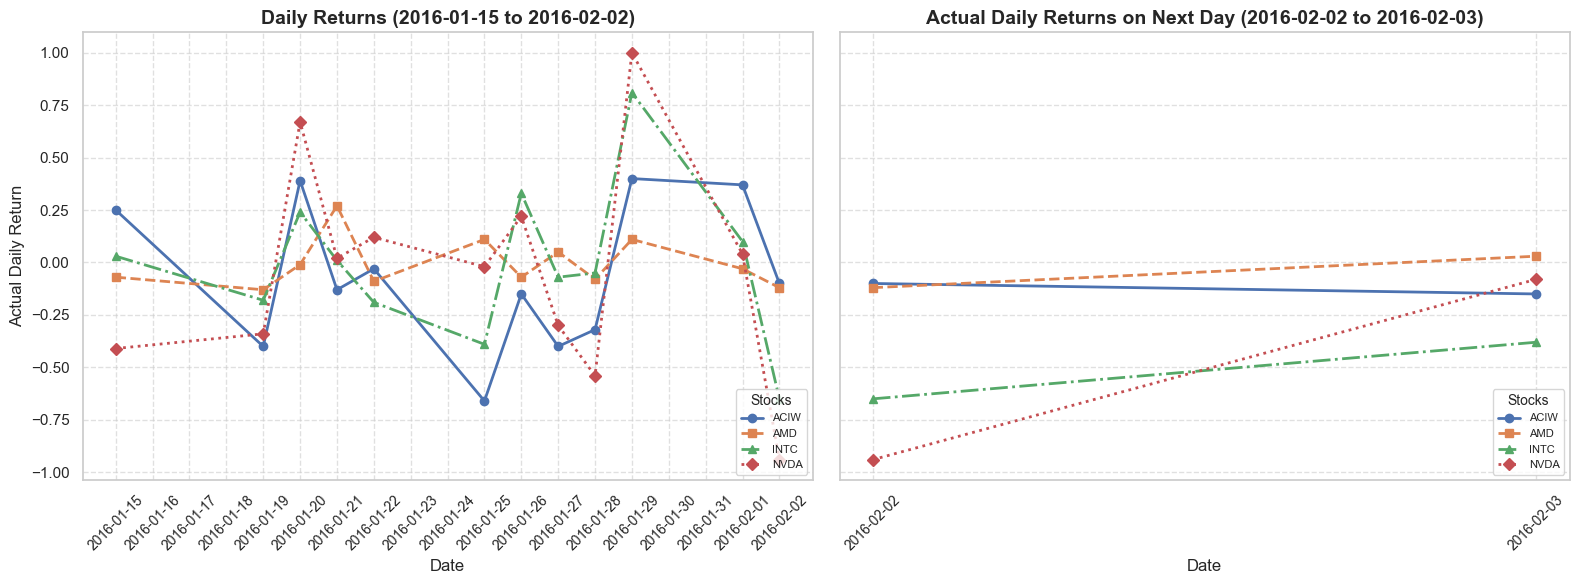

In [6]:
from src.utils.plot_stocks_return import plot_daily_returns_comparison

# Configurations
stocks_dir = r"data/stocks"
start_date2 = "2016-02-02"
end_date2 = "2016-02-03"

target_companies = ['ACIW','AMD', 'INTC', 'NVDA']

# Plot daily returns comparison and get actual returns
actual_stocks_returns = plot_daily_returns_comparison(stocks_dir, target_companies, start_date, end_date, start_date2, end_date2)

- ### *Stocks using MSAR*

In [7]:
""" 
We filter the tensor to retain only data corresponding to the selected 4 companies for our analysis.
"""
# Find indices of the target companies in retained_symbols
indices = [retained_symbols.index(company) for company in target_companies if company in retained_symbols]

# Filter the tensor and retained_symbols
filtered_tensor = tensor[:, indices]

filtered_symbols = [retained_symbols[i] for i in indices]
market_avg_tensor = torch.mean(filtered_tensor, axis=1, keepdim=True) # Group Individuals stocks to reflect the marke situation in the Technology Sector

# Output the results
print(f"Filtered Tensor Shape: {filtered_tensor.shape}")
print (f"Market Tensor Shape: {market_avg_tensor.shape}")
print(f"Filtered Companies: {filtered_symbols}")

Filtered Tensor Shape: torch.Size([12, 4])
Market Tensor Shape: torch.Size([12, 1])
Filtered Companies: ['ACIW', 'AMD', 'INTC', 'NVDA']


In [8]:
""" 
For each individual stock (company), we fitted an MSAR model WITHOUT CEO speech emotion variables to identify the underlying regimes and to predict the expected daily return for the following day.
"""
# Reshape the tensor to (k, n, m)
reshaped_tensor = filtered_tensor.unsqueeze(0)  # Shape becomes (1, n, m)

# MSAR Model Application
import src.models.msar as msar
from src.utils.data_handler import extract_msar_predictions

stocks_info = msar.msar(
        T=reshaped_tensor, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        exog_tvtp=None # No CEO speech features
    )

# Extract predictions for each company using the helper function
stocks_msar_predictions = extract_msar_predictions(msar, stocks_info, filtered_symbols, print_analysis=False) # Turn the print_analysis to True, to show the detailed prediction and analysis results

In [9]:
""" 
We used four selected stocks to represent the technology market. By taking the average of the daily returns of these four individual stocks, we constructed a proxy for the market and used it to analyze overall market conditions.
"""
# market average of the individual technology stocks
reshaped_market = market_avg_tensor.unsqueeze(0)  # Shape becomes (1, n, m)
market_info = msar.msar(
        T=reshaped_market, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        exog_tvtp=None # No CEO speech features
    )

# Extract market prediction
msar.analyze_info(market_info, c=0, i=0)

# Extract the market prediction value
exp_next = market_info["summary"]["exp_next"]
if hasattr(exp_next, 'shape'):
    if len(exp_next.shape) == 2:
        market_msar_prediction = exp_next[0, 0]
    else:
        market_msar_prediction = exp_next[0]
else:
    market_msar_prediction = exp_next[0]

if isinstance(market_msar_prediction, (list, tuple)):
    market_msar_prediction = market_msar_prediction[0]
if hasattr(market_msar_prediction, 'item'):
    market_msar_prediction = market_msar_prediction.item()
market_msar_prediction = float(market_msar_prediction)

print(f"\nMarket MSAR Prediction: {market_msar_prediction}")

One-step-ahead regime probabilities
---------------------------------------------
μ by regime     : [-0.00274256  0.0319884 ]
σ² by regime    : [0.95525046 0.95525046]
φ by regime     : [-0.23829046 -0.23829046]
Current state probabilities p(s_t | Y₁:ₜ): [1.05209044e-20 1.00000000e+00]
Predicted next  probabilities p(sₜ₊₁ | Y₁:ₜ): [3.28762052e-32 1.00000000e+00]
→ Current regime  : Bull  (Regime 1)  (p=1.000)
→ Next predicted  : Bull  (Regime 1)  (p=1.000)
✅ Market likely remains in *Bull regime*.

One-step-ahead expected return
---------------------------------------------
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (std): [0.35435126 0.38908223]
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (raw): [0.07273808 0.08258312]
E[rₜ₊₁ | Y₁:ₜ] (std) = 0.389082
E[rₜ₊₁ | Y₁:ₜ] (raw) = 0.0825831


Market MSAR Prediction: 0.08258312397762918


- ### *(Alternative) Stocks using LSTM*

We next apply a LSTM neural network as an alternative baseline model to predict next-day returns. Unlike the MSAR framework, which assumes discrete regime switches, the LSTM model captures continuous temporal dependencies through its recurrent architecture. To ensure a fair and controlled comparison with MSAR, we set the look-back window to one day (`LookBack = 1`), using only the previous day’s return to predict the next-day return. This design choice aligns the information set of the LSTM model as closely as possible with that of the MSAR model, whose predictions depend solely on the immediately preceding latent state.

In [12]:
from src.models.lstm_baseline import *
import numpy as np

filtered_tensor_np = filtered_tensor.detach().numpy()  # Shape: (12, 4)
market_avg_tensor_np = market_avg_tensor.detach().numpy()

# ===== LSTM Prediction Pipeline =====
# Parameters
LOOKBACK = 1  # Use 1 days to predict the next day
EPOCHS = 50
BATCH_SIZE = 4

# Prepare training data
X_train, y_train = prepare_lstm_data(filtered_tensor_np, lookback=LOOKBACK)

lstm_predictions = {}

for stock_idx in range(filtered_tensor_np.shape[1]):
    stock_name = filtered_symbols[stock_idx]    
    # Build model for single stock
    model = build_lstm_model(input_shape=(LOOKBACK, 4), loss="Huber")
    
    # Train the model
    history = model.fit(
        X_train, 
        y_train[:, stock_idx],  # Target for this stock
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        validation_split=0.2
    )
    
    # Use the last 'lookback' days to predict the next day
    last_sequence = filtered_tensor_np[-LOOKBACK:].reshape(1, LOOKBACK, 4)
    prediction = model.predict(last_sequence, verbose=0)
    
    lstm_predictions[stock_name] = float(prediction[0][0])
    
    # print(f"Training Loss: {history.history['loss'][-1]:.6f}")
    # print(f"Validation Loss: {history.history['val_loss'][-1]:.6f}")
    # print(f"Predicted next-day return: {lstm_predictions[stock_name]:.6f}")

for stock, pred in lstm_predictions.items():
    print(f"{stock}: {pred:.6f}")

ACIW: -0.173745
AMD: -0.178592
INTC: -0.046036
NVDA: -0.117042


In [13]:
# ===== Market-Level LSTM Prediction =====
# Train a separate LSTM model on the market average time series
market_avg_np = market_avg_tensor.detach().numpy().squeeze()  # Shape: (12,)

# Prepare market training data (same lookback)
X_market_train, y_market_train = prepare_lstm_data(
    market_avg_np.reshape(-1, 1),  # Reshape to (12, 1)
    lookback=LOOKBACK
)

# Train LSTM on market series
market_lstm_model = build_lstm_model(input_shape=(LOOKBACK, 1), loss="Huber")

market_history = market_lstm_model.fit(
    X_market_train,
    y_market_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    validation_split=0.2
)

# Predict market return
last_market_sequence = market_avg_np[-LOOKBACK:].reshape(1, LOOKBACK, 1)
market_lstm_prediction = float(market_lstm_model.predict(last_market_sequence, verbose=0)[0][0])
print(f"\n{'='*50}")
print("LSTM Predictions on Market:")
print(f"{'='*50}")
print(market_lstm_prediction)


LSTM Predictions on Market:
-0.04538235813379288


### *Incorporating CEO Speech Information into MSAR*

In the baseline MSAR framework, transition probabilities between latent states are typically assumed to be constant over time, implying that regime switches are driven solely by the internal dynamics of the hidden state process. However, in real financial markets, regime transitions are often influenced by **exogenous information shocks**, particularly those conveyed through forward-looking communication by corporate executives. Motivated by this consideration, we augment the MSAR model by incorporating **CEO speech–based uncertainty** as an exogenous variable in the state transition mechanism, thereby allowing for **time-varying transition probabilities (TVTP)**.

The key **motivation** for introducing TVTP is that elevated uncertainty expressed in CEO speeches may alter investors’ perceptions of future firm performance and risk, which in turn can **affect the likelihood of switching between market regimes**. Compared to fixed transition probabilities, this specification enables the model to capture how “soft information” embedded in managerial communication influences the stability and persistence of latent market states in a more economically meaningful way.

Technically, the incorporation of TVTP is achieved by mapping the exogenous uncertainty measure into valid transition probabilities through a **logistic (sigmoid) function**. Let $z_t$ denote the uncertainty index extracted from CEO speech at time $t$. The transition probability from state $i$ to state $j$ is specified as

$$
p_{ij,t}
= \frac{\exp\left(\alpha_{ij} + \beta_{ij} z_t\right)}
{\sum_{k} \exp\left(\alpha_{ik} + \beta_{ik} z_t\right)} .
$$

Here, $\alpha_{ij}$ captures the baseline propensity of transitioning from state $i$ to state $j$, while $\beta_{ij}$ measures the marginal impact of CEO speech uncertainty on the transition dynamics. The sigmoid structure guarantees that transition probabilities lie in the unit interval $(0,1)$ and allows exogenous information to affect regime switches in a **smooth and interpretable** manner.

From a modeling perspective, introducing TVTP preserves the overall structure of the MSAR model while enhancing its flexibility at the regime-switching level. From an economic standpoint, this extension directly links textual measures of uncertainty to changes in regime persistence and fragility, enabling the model to better capture **information-driven regime transition mechanisms** in financial markets.


- ### *Stocks using MSAR with CEO speech*

In [14]:
CEO_speech = pd.read_excel('src/data_cleaned/processed_NLP/lstm_input_cumret3.xlsx')
CEO_speech["date"] = pd.to_datetime(CEO_speech["date"])

emotion_features = CEO_speech[
    (CEO_speech["date"] >= start_date) & (CEO_speech["date"] <= end_date)
][["uncertainty_z"]]

# Standardize emotion_features (mean=0, std=1)
norm_emotion_features = (emotion_features - emotion_features.mean()) / emotion_features.std()

""" 
For each individual stock (company), we fitted an MSAR model WITH CEO speech emotion variables to identify the underlying regimes and to predict the expected daily return for the following day.
"""
stocks_emo_info = msar.msar(
        T=reshaped_tensor, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        exog_tvtp=norm_emotion_features,
    )

# Extract predictions for each company with CEO linguistic features
stocks_emo_predictions = extract_msar_predictions(msar, stocks_emo_info, filtered_symbols, print_analysis=False) # Turn the print_analysis to True, to show the detailed prediction and analysis results

In [15]:
""" 
Similalry, we used four selected stocks to represent the technology market, but just considering CEO speech factor at this time.
"""
market_emo_info = msar.msar(
        T=reshaped_market, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        exog_tvtp=norm_emotion_features,
    )

# Extract market prediction with CEO features
msar.analyze_info(market_emo_info, c=0, i=0)

# Extract the market prediction value
exp_next = market_emo_info["summary"]["exp_next"]
if hasattr(exp_next, 'shape'):
    if len(exp_next.shape) == 2:
        market_emo_prediction = exp_next[0, 0]
    else:
        market_emo_prediction = exp_next[0]
else:
    market_emo_prediction = exp_next[0]

if isinstance(market_emo_prediction, (list, tuple)):
    market_emo_prediction = market_emo_prediction[0]
if hasattr(market_emo_prediction, 'item'):
    market_emo_prediction = market_emo_prediction.item()
market_emo_prediction = float(market_emo_prediction)

print(f"\nMarket MSAR CEO Linguistic Prediction: {market_emo_prediction}")

One-step-ahead regime probabilities
---------------------------------------------
μ by regime     : [-0.37090765  1.69222793]
σ² by regime    : [0.37476813 0.37476813]
φ by regime     : [-0.05442519 -0.05442519]
Current state probabilities p(s_t | Y₁:ₜ): [1.00000000e+00 8.98912114e-26]
Predicted next  probabilities p(sₜ₊₁ | Y₁:ₜ): [1. 0.]
→ Current regime  : Bear  (Regime 0)  (p=1.000)
→ Next predicted  : Bear  (Regime 0)  (p=1.000)
⚠️ Market likely remains in *Bear regime*.

One-step-ahead expected return
---------------------------------------------
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (std): [-0.28934794  1.77378764]
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (raw): [-0.10972869  0.47509988]
E[rₜ₊₁ | Y₁:ₜ] (std) = -0.289348
E[rₜ₊₁ | Y₁:ₜ] (raw) = -0.109729


Market MSAR CEO Linguistic Prediction: -0.10972869163887516


- ### *(Alternative) Stocks using LSTM with CEO speech*
We further extend the input feature set by incorporating CEO linguistic variables in addition to the four stock return series. This enriched input representation allows the LSTM model to exploit potential interactions and cross-relationships between financial market dynamics and managerial communication patterns.

In [16]:
uncertainty_array = norm_emotion_features.values
combined_features = np.concatenate([filtered_tensor_np, uncertainty_array], axis=1)

# Prepare training data, now with 5 features: 4 stocks + 1 additional CEO emotion feature
X_train, y_train = prepare_lstm_data(combined_features, lookback=LOOKBACK)

lstm_ceo_predictions = {}

for stock_idx in range(filtered_tensor_np.shape[1]):
    stock_name = filtered_symbols[stock_idx]
    
    # Build model with 5 input features (4 stocks + 1 CEO uncertainty)
    model = build_lstm_model(input_shape=(LOOKBACK, 5), loss="Huber")
    
    # Train the model
    history = model.fit(
        X_train, 
        y_train[:, stock_idx],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        validation_split=0.2
    )
    
    # Use the last 'lookback' days (with CEO feature) to predict
    last_sequence = combined_features[-LOOKBACK:].reshape(1, LOOKBACK, 5)
    prediction = model.predict(last_sequence, verbose=0)
    
    lstm_ceo_predictions[stock_name] = float(prediction[0][0])

for stock, pred in lstm_ceo_predictions.items():
    print(f"{stock}: {pred:.6f}")

c:\Users\kingx\anaconda3\envs\ada\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ACIW: -0.147216
AMD: -0.160378
INTC: -0.129549
NVDA: -0.054568


In [17]:
# ===== Market-Level LSTM Prediction with CEO Features =====
# Combine market series with CEO uncertainty for market prediction

# Concatenate market average with CEO uncertainty (12 x 2)
market_ceo_features = np.concatenate([
    market_avg_np.reshape(-1, 1),     # (12, 1) - market returns
    uncertainty_array                  # (12, 1) - CEO uncertainty
], axis=1)

# Prepare training data
X_market_ceo_train, y_market_ceo_train = prepare_lstm_data(
    market_ceo_features,
    lookback=LOOKBACK
)

# Train LSTM on market+CEO series
market_lstm_ceo_model = build_lstm_model(input_shape=(LOOKBACK, 2), loss="Huber")

market_ceo_history = market_lstm_ceo_model.fit(
    X_market_ceo_train,
    y_market_ceo_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    validation_split=0.2
)

# Predict market return with CEO features
last_market_ceo_sequence = market_ceo_features[-LOOKBACK:].reshape(1, LOOKBACK, 2)
market_lstm_ceo_prediction = float(market_lstm_ceo_model.predict(last_market_ceo_sequence, verbose=0)[0][0])

print(f"\n{'='*50}")
print("LSTM Predictions with CEO Speech on Market:")
print(f"{'='*50}")
print(market_lstm_ceo_prediction)


LSTM Predictions with CEO Speech on Market:
-0.02058636210858822


- ### *Stocks Results*

In [18]:
# Create summary table with errors for individual stocks
actual_vals = [actual_stocks_returns.get(company, None) for company in filtered_symbols]
raw_preds = [stocks_msar_predictions.get(company, None) for company in filtered_symbols]
emo_preds = [stocks_emo_predictions.get(company, None) for company in filtered_symbols]
lstm_preds = [lstm_predictions.get(company, None) for company in filtered_symbols]
lstm_ceo_preds = [lstm_ceo_predictions.get(company, None) for company in filtered_symbols]

# Calculate errors (Actual - Prediction)
raw_errors = [abs(actual - pred) if actual is not None and pred is not None else None 
              for actual, pred in zip(actual_vals, raw_preds)]
emo_errors = [abs(actual - pred) if actual is not None and pred is not None else None 
              for actual, pred in zip(actual_vals, emo_preds)]
lstm_errors = [abs(actual - pred) if actual is not None and pred is not None else None 
               for actual, pred in zip(actual_vals, lstm_preds)]
lstm_ceo_errors = [abs(actual - pred) if actual is not None and pred is not None else None 
                   for actual, pred in zip(actual_vals, lstm_ceo_preds)]

# Calculate market average actual return
market_actual_return = sum([v for v in actual_vals if v is not None]) / len([v for v in actual_vals if v is not None])


# Calculate market errors
market_raw_error = abs(market_actual_return - market_msar_prediction)
market_emo_error = abs(market_actual_return - market_emo_prediction)
market_lstm_error = abs(market_actual_return - market_lstm_prediction)
market_lstm_ceo_error = abs(market_actual_return - market_lstm_ceo_prediction)

# Create individual stocks dataframe
stocks_results = pd.DataFrame({
    'Company': filtered_symbols,
    'Actual Return': actual_vals,
    'MSAR Prediction': raw_preds,
    'MSAR+CEO Prediction': emo_preds,
    'LSTM Prediction': lstm_preds,
    'LSTM+CEO Prediction': lstm_ceo_preds,
    'MSAR abs Error': raw_errors,
    'MSAR+CEO abs Error': emo_errors,
    'LSTM abs Error': lstm_errors,
    'LSTM+CEO abs Error': lstm_ceo_errors
})

# Add market average row
market_row = pd.DataFrame({
    'Company': ['Market Average'],
    'Actual Return': [market_actual_return],
    'MSAR Prediction': [market_msar_prediction],
    'MSAR+CEO Prediction': [market_emo_prediction],
    'LSTM Prediction': [market_lstm_prediction],
    'LSTM+CEO Prediction': [market_lstm_ceo_prediction],
    'MSAR abs Error': [market_raw_error],
    'MSAR+CEO abs Error': [market_emo_error],
    'LSTM abs Error': [market_lstm_error],
    'LSTM+CEO abs Error': [market_lstm_ceo_error]
})

stocks_results = pd.concat([stocks_results, market_row], ignore_index=True)

stocks_results

,Company,Actual Return,MSAR Prediction,MSAR+CEO Prediction,LSTM Prediction,LSTM+CEO Prediction,MSAR abs Error,MSAR+CEO abs Error,LSTM abs Error,LSTM+CEO abs Error
0,ACIW,-0.150002,-0.090302,-0.202081,-0.173745,-0.147216,0.059700,0.052080,0.023744,0.002786
1,AMD,0.030000,0.042955,0.056815,-0.178592,-0.160378,0.012955,0.026815,0.208592,0.190378
2,INTC,-0.379999,0.095551,-0.028468,-0.046036,-0.129549,0.475551,0.351532,0.333963,0.250450
3,NVDA,-0.080000,0.218776,-0.259075,-0.117042,-0.054568,0.298776,0.179075,0.037042,0.025432
4,Market Average,-0.145000,0.082583,-0.109729,-0.045382,-0.020586,0.227583,0.035271,0.099618,0.124414


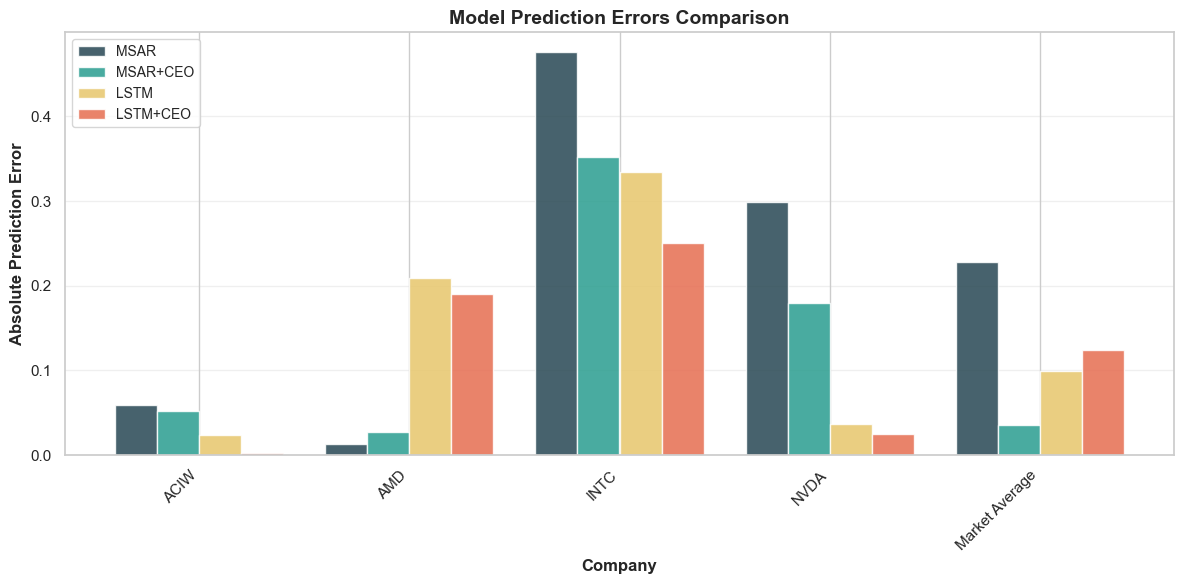

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

companies = stocks_results['Company'].values
x_pos = np.arange(len(companies))
width = 0.2

# Get error values
msar_err = stocks_results['MSAR abs Error'].values
msar_ceo_err = stocks_results['MSAR+CEO abs Error'].values
lstm_err = stocks_results['LSTM abs Error'].values
lstm_ceo_err = stocks_results['LSTM+CEO abs Error'].values

# Create grouped bar chart for errors
ax.bar(x_pos - 1.5*width, msar_err, width, label='MSAR', color='#274753', alpha=0.85)
ax.bar(x_pos - 0.5*width, msar_ceo_err, width, label='MSAR+CEO', color='#299d8f', alpha=0.85)
ax.bar(x_pos + 0.5*width, lstm_err, width, label='LSTM', color='#e7c66b', alpha=0.85)
ax.bar(x_pos + 1.5*width, lstm_ceo_err, width, label='LSTM+CEO', color='#e66d50', alpha=0.85)

ax.set_xlabel('Company', fontsize=12, fontweight='bold')
ax.set_ylabel('Absolute Prediction Error', fontsize=12, fontweight='bold')
ax.set_title('Model Prediction Errors Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(companies, rotation=45, ha='right')
ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### ***Stocks Interpretation and Validation***
- By inspecting the graph, we observe that for the majority of the sample period, incorporating CEO speech information helps reduce prediction error. At a minimum, the inclusion of linguistic features does not materially deteriorate the predictive performance relative to the model without CEO speech information (**MSAR for AMD**).

- By comparing the predicted results with the realized data, we find that for firms such as **ACIW**, **INTC** and **NVDA**, whose stock prices exhibit relatively high volatility, the baseline MSAR model struggles to deliver accurate predictions. In contrast, when CEO speech information is incorporated as an exogenous variable and embedded into the model through a **time-varying transition probability (TVTP)** structure, the prediction error is **substantially reduced**.  
  This improvement can be attributed to the fact that **high firm-level volatility is often closely associated with broader industry- and market-level volatility**. Such macro-level uncertainty is frequently reflected in CEOs’ public communications, which convey strategic outlooks and risk perceptions from a more aggregate perspective. **By incorporating CEO speech information—particularly its measured uncertainty—into the regime-switching mechanism**, the model becomes more sensitive to changes in the underlying economic environment. Intuitively, **higher uncertainty in CEO speech corresponds to a greater likelihood of regime transitions**, thereby enhancing the model’s ability to capture abrupt structural shifts in highly volatile stocks.

- For stocks with relatively low volatility **(AMD)**, however, the original MSAR model exhibits superior performance even without additional exogenous information. This result arises because the uncertainty measure derived from CEO speech is constructed as an **average across multiple firms**, which primarily captures the **overall trend of industry-level changes**. As a consequence, this aggregate measure may be less informative for firms whose stock price dynamics are **weakly influenced by industry-wide movements**, due to firm-specific characteristics or idiosyncratic factors. In such cases, historical price data contain **more stable and exploitable regularities**, enabling the baseline MSAR model to generate more accurate predictions without relying on external uncertainty indicators.

- In addition, at the market-average level, we observe a pronounced reduction in absolute prediction errors after incorporating CEO speech information. This improvement arises because both the market average and CEO speech uncertainty capture the overall market-wide conditions. Consequently, introducing this highly correlated exogenous variable substantially enhances the model’s predictive performance.

- Alternatively, the results indicate that LSTM models are better suited to highly volatile assets characterized by complex and nonlinear dynamics, whereas MSAR models are more effective for less volatile assets, where regime changes are relatively infrequent and can be adequately captured by a simpler Markov-switching structure. This observation provides the intuition for a potential model-switching mechanism in future work: asset volatility—measured, for example, by the rolling standard deviation of returns—could be used as a decision criterion. When high volatility is detected, the LSTM model would be preferred, whereas under low-volatility conditions, the MSAR model would be employed.

- ### ***ETFs Examples***
Similarly, we also perform the analysis on a set of ETFs over the period **2016-01-15 to 2016-02-02**.

Data is complete, no NaN values.
Tensor Shape: torch.Size([12, 10])
Date Range: 2016-01-15 to 2016-02-02
ETF Symbols: ['FDN', 'FTEC', 'PSCT', 'QTEC', 'RYT', 'SOXX', 'TDIV', 'XNTK', 'XSD', 'XSW']
Skipped Symbols: ['FITE', 'HAIL', 'XTH', 'XWEB']

Statistics for 2016-02-03 (day after start_date2):

Individual Stock/ETF Returns (Close - Open):
  FDN     :  -1.2800
  FTEC    :  -0.2400
  PSCT    :   0.1500
  QTEC    :  -0.1200
  RYT     :  -0.2400
  SOXX    :  -0.8700
  TDIV    :   0.0600
  XNTK    :  -0.2100
  XSD     :  -0.4300
  XSW     :   0.3500

------------------------------------------------------------
Market Summary:
  Average Return: -0.2830
  Std Deviation:  0.4832
  Number of stocks: 10



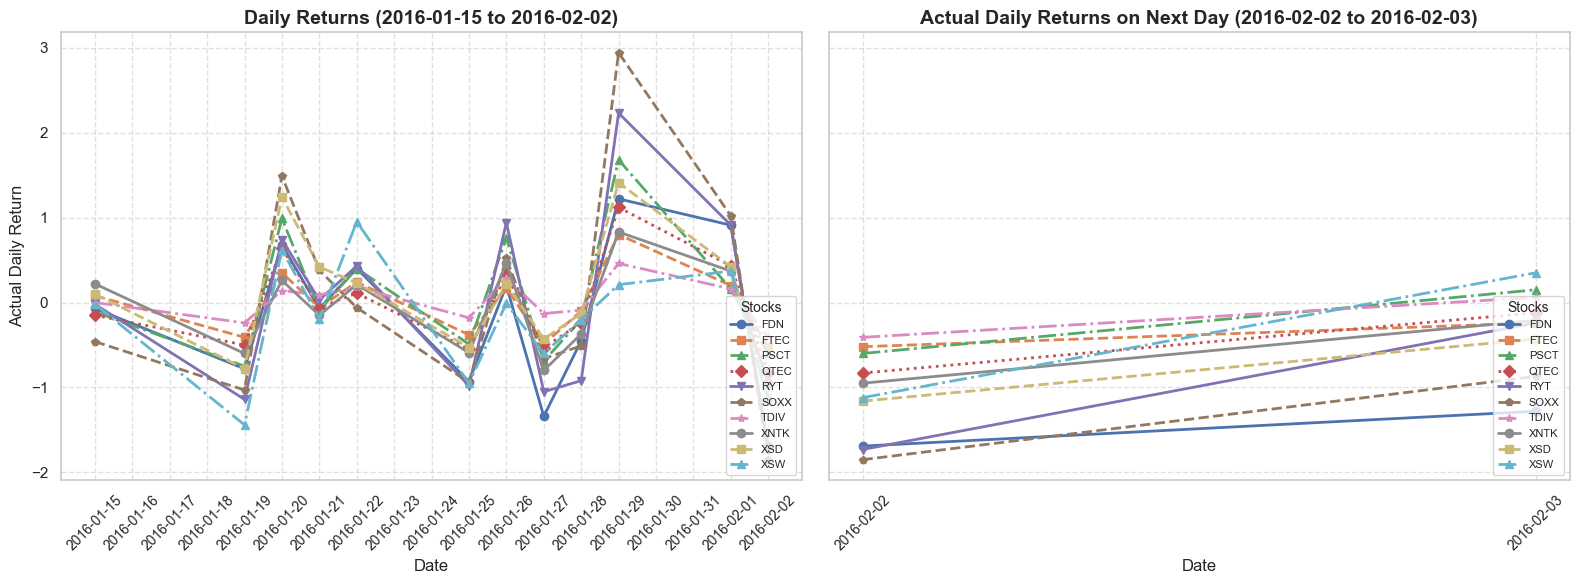

In [24]:
from src.utils.plot_stocks_return import plot_daily_returns_comparison
from src.utils.data_handler import process_data

# file paths
category_file = r"src/data_cleaned/index_etfs_with_industry.csv"
etfs_dir = r"data/etfs"

"""filter out Technology ETFs and save the result"""
# tech_etfs = pd.read_csv(category_file)
# tech_etfs = tech_etfs[tech_etfs['Industry'] == 'Technology']
# tech_etfs.to_csv(r"src/data_cleaned/etfs_technology.csv", index=False)

sector_file = r"src/data_cleaned/etfs_technology.csv"

# time window
start_date = "2016-01-15"
end_date = "2016-02-02"

# process ETF data
etfs_tensor, etfs_dates, etfs_symbols, etfs_skipped = process_data(sector_file, etfs_dir, start_date, end_date)

# outputs
if etfs_tensor is not None:
    print(f"Tensor Shape: {etfs_tensor.shape}")
    print(f"Date Range: {etfs_dates[0]} to {etfs_dates[-1]}")
    print(f"ETF Symbols: {etfs_symbols}")
else:
    print("Error in generating tensor.")

print(f"Skipped Symbols: {etfs_skipped}")

# Validation period
validate_start = "2016-02-02"
validate_end = "2016-02-03"

# Plot daily returns comparison and get actual returns
actual_etfs_returns = plot_daily_returns_comparison(etfs_dir, etfs_symbols, start_date, end_date, validate_start, validate_end)

- ### *ETFs using MSAR*

In [25]:
# Reshape the tensor to (k, n, m)
k = 1
n, m = etfs_tensor.shape
reshaped_etfs_tensor = etfs_tensor.unsqueeze(0)  # Shape becomes (1, n, m)

import src.models.msar as msar
from src.utils.data_handler import extract_msar_predictions

etfs_info = msar.msar(
        T=reshaped_etfs_tensor, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        exog_tvtp=None # No CEO speech features
    )

etfs_msar_predictions = extract_msar_predictions(msar, etfs_info, etfs_symbols, print_analysis=True)


Analysis for FDN (index 0):
One-step-ahead regime probabilities
---------------------------------------------
μ by regime     : [-0.01748355  0.02625273]
σ² by regime    : [0.94393692 0.94393692]
φ by regime     : [-0.27725219 -0.27725219]
Current state probabilities p(s_t | Y₁:ₜ): [1.06575709e-20 1.00000000e+00]
Predicted next  probabilities p(sₜ₊₁ | Y₁:ₜ): [3.28612749e-32 1.00000000e+00]
→ Current regime  : Bull  (Regime 1)  (p=1.000)
→ Next predicted  : Bull  (Regime 1)  (p=1.000)
✅ Market likely remains in *Bull regime*.

One-step-ahead expected return
---------------------------------------------
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (std): [0.45124747 0.49498375]
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (raw): [0.24837348 0.28795417]
E[rₜ₊₁ | Y₁:ₜ] (std) = 0.494984
E[rₜ₊₁ | Y₁:ₜ] (raw) = 0.287954


Analysis for FTEC (index 1):
One-step-ahead regime probabilities
---------------------------------------------
μ by regime     : [-0.02396674  0.01021304]
σ² by regime    : [0.92495586 0.92495

- ### *ETFs using MSAR with CEO speech*

In [26]:
etfs_emo_info = msar.msar(
        T=reshaped_etfs_tensor, 
        k_regimes=2,          
        order=1,              
        switching_ar=False,
        switching_variance=False,
        trend="c",
        exog_tvtp=norm_emotion_features
    )

etfs_emo_predictions = extract_msar_predictions(msar, etfs_emo_info, etfs_symbols, print_analysis=True)


Analysis for FDN (index 0):
One-step-ahead regime probabilities
---------------------------------------------
μ by regime     : [-0.41509208  1.15638506]
σ² by regime    : [0.45606334 0.45606334]
φ by regime     : [-0.21585318 -0.21585318]
Current state probabilities p(s_t | Y₁:ₜ): [9.99995671e-01 4.32916017e-06]
Predicted next  probabilities p(sₜ₊₁ | Y₁:ₜ): [9.99999974e-01 2.56820166e-08]
→ Current regime  : Bear  (Regime 0)  (p=1.000)
→ Next predicted  : Bear  (Regime 0)  (p=1.000)
⚠️ Market likely remains in *Bear regime*.

One-step-ahead expected return
---------------------------------------------
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (std): [-0.0501641   1.52131303]
Regime-wise E[rₜ₊₁ | sₜ₊₁=j, Y₁:ₜ] (raw): [-0.20539668  1.21676718]
E[rₜ₊₁ | Y₁:ₜ] (std) = -0.0501641
E[rₜ₊₁ | Y₁:ₜ] (raw) = -0.205397


Analysis for FTEC (index 1):
One-step-ahead regime probabilities
---------------------------------------------
μ by regime     : [-0.3534421   1.45959782]
σ² by regime    : [0.48836499

In [27]:
# Create summary table with errors for ETFs
actual_vals = [actual_etfs_returns.get(company, None) for company in etfs_symbols]
raw_preds = [etfs_msar_predictions.get(company, None) for company in etfs_symbols]
emo_preds = [etfs_emo_predictions.get(company, None) for company in etfs_symbols]

# Calculate errors (Actual - Prediction)
raw_errors = [abs(actual - pred) if actual is not None and pred is not None else None 
              for actual, pred in zip(actual_vals, raw_preds)]
emo_errors = [abs(actual - pred) if actual is not None and pred is not None else None 
              for actual, pred in zip(actual_vals, emo_preds)]

etfs_results = pd.DataFrame({
    'ETF': etfs_symbols,
    'Actual Return': actual_vals,
    'MSAR Prediction': raw_preds,
    'MSAR+CEO Prediction': emo_preds,
    'MSAR Raw abs Error': raw_errors,
    'MSAR+CEO abs Error': emo_errors
})

etfs_results.to_string(index=False, float_format=lambda x: f"{x:.6f}")

etfs_results

,ETF,Actual Return,MSAR Prediction,MSAR+CEO Prediction,MSAR Raw abs Error,MSAR+CEO abs Error
0,FDN,-1.280006,0.287954,-0.205397,1.567961,1.074610
1,FTEC,-0.240000,0.141556,-0.083167,0.381556,0.156833
2,PSCT,0.150002,0.371522,-0.178135,0.221521,0.328136
3,QTEC,-0.119999,0.209546,-0.096167,0.329545,0.023832
4,RYT,-0.239998,0.528419,-0.250845,0.768416,0.010847
5,SOXX,-0.870003,0.351129,-0.335470,1.221131,0.534533
6,TDIV,0.059999,0.192021,0.026084,0.132021,0.033915
7,XNTK,-0.209999,0.293956,0.109145,0.503955,0.319144
8,XSD,-0.430000,0.359815,-0.211194,0.789815,0.218807
9,XSW,0.349998,0.322434,0.224903,0.027564,0.125095


### ***ETF-Level Interpretation and Validation***
- This section provides an interpretation and validation of the proposed MSAR framework at the ETF level. As ETFs aggregate returns across multiple firms, their dynamics are largely driven by industry-wide and market-wide conditions rather than firm-specific shocks, making them a natural setting to assess the role of aggregate information in regime-switching models. 
- By comparing the baseline MSAR model with its extension incorporating CEO speech information, we find that the inclusion of linguistic uncertainty leads to a systematic reduction in prediction errors for most ETFs. This result suggests that CEO speech effectively captures market-level uncertainty relevant for regime transitions, thereby enhancing the model’s ability to identify common structural shifts and improving predictive performance.

### ***Potential Future work\*: Extension to Multi-Industry Tensor*** 

Beyond analyzing stocks within a single industry sector, we can construct a **multi-industry tensor** by stacking data from multiple sectors, as illustrated in the example below. With appropriate financial data and corresponding CEO speech data, this framework enables future exploration of cross-industry interactions and spillover effects.

In [28]:
from src.utils.data_handler import process_multi_industry

# file paths
categories_dir = r"src/data_cleaned/stocks_categories"
stocks_dir = r"data/stocks"

industries = ["energy", "healthcare", "technology", "real_estate"]  # example industries
start_date = "2000-08-08"
end_date = "2000-09-08"
n_companies = 5  # Number of companies per industry. The numbers may vary by industry. Here we use a simple fixed number for demonstration.

# Process multi-industry data
stacked_tensor, industry_names, industry_company_labels = process_multi_industry(
    industries, categories_dir, stocks_dir, start_date, end_date, n_companies
)

# Output results
if stacked_tensor is not None:
    print(f"Stacked tensor shape: {stacked_tensor.shape}")
else:
    print("No valid data for industries.")
# 
# for i, industry in enumerate(industry_names):
#     print(f"Industry: {industry}")
#     print(f"Companies: {industry_company_labels[i]}")

NaN counts per company:
PBR    2
dtype: int64
Dates with NaN values: [Timestamp('2000-08-08 00:00:00'), Timestamp('2000-08-09 00:00:00')]
NaN counts per company:
CGEN     3
INMD     1
TAK     22
dtype: int64
Dates with NaN values: [Timestamp('2000-08-08 00:00:00'), Timestamp('2000-08-09 00:00:00'), Timestamp('2000-08-10 00:00:00'), Timestamp('2000-08-11 00:00:00'), Timestamp('2000-08-14 00:00:00'), Timestamp('2000-08-15 00:00:00'), Timestamp('2000-08-16 00:00:00'), Timestamp('2000-08-17 00:00:00'), Timestamp('2000-08-18 00:00:00'), Timestamp('2000-08-21 00:00:00'), Timestamp('2000-08-22 00:00:00'), Timestamp('2000-08-23 00:00:00'), Timestamp('2000-08-24 00:00:00'), Timestamp('2000-08-25 00:00:00'), Timestamp('2000-08-29 00:00:00'), Timestamp('2000-08-30 00:00:00'), Timestamp('2000-08-31 00:00:00'), Timestamp('2000-09-01 00:00:00'), Timestamp('2000-09-05 00:00:00'), Timestamp('2000-09-06 00:00:00'), Timestamp('2000-09-07 00:00:00'), Timestamp('2000-09-08 00:00:00')]
NaN counts per compa

In [29]:
print("First industry (energy) - Complete matrix:")
print(stacked_tensor[:, :, 0])
# print("\nSecond industry (healthcare) - Complete matrix:")  
# print(stacked_tensor[:, :, 1])


First industry (energy) - Complete matrix:
tensor([[ 0.0541,  0.2706,  0.3247,  0.1623,  1.0823, -0.6494,  0.2164,  0.8117,
         -0.5141, -0.1623, -0.0135,  0.6899, -0.2976,  0.3517,  0.3111,  0.2570,
         -0.2706,  0.0541,  0.4600,  0.0271,  0.6223, -0.0541, -0.6223],
        [-0.6259,  0.4024, -0.0447,  0.6259,  1.0730, -0.8941,  0.5365,  2.4142,
         -0.9835,  1.6094,  0.0894,  0.4471, -0.4471, -0.8494,  0.2235,  3.1295,
         -1.3859, -0.4471,  0.8494,  0.0894, -1.2071,  1.3412, -0.9388],
        [-0.0848, -0.0446, -0.0312,  0.0603, -0.0379, -0.0402,  0.1161,  0.2188,
         -0.0982,  0.0179,  0.0759,  0.2031,  0.1027,  0.0223,  0.0580,  0.0938,
          0.0357,  0.1406,  0.1518, -0.0156, -0.2098,  0.2054, -0.1964],
        [ 0.0625, -0.2500,  0.2500,  0.0625, -0.2500, -0.1250, -0.8125,  0.1250,
          0.3125, -0.1250, -0.3750,  0.1875, -0.1250,  0.3125, -0.2500,  0.2500,
          0.1875,  0.3125, -0.1250,  0.1250, -0.3125,  0.3750,  0.3125]])
